# Model: Random Forest with all the columns and hyperparmeters optimisation

In this notebook, all the training/predictions steps are implemented for a very basic model (random forest with all the features). 
The goal is to get the best f1-score ! May the force be with you 🧨🧨  

# Import libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, recall_score,precision_score, RocCurveDisplay
from sklearn.pipeline import Pipeline

import optuna
import matplotlib.pyplot as plt
import plotly.express as px

/home/nick/.virtualenvs/conversion-rate-challenge/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Read file with labels

In [2]:
data = pd.read_csv('../data/processed/conversion_data_train_EDA_without_outliers_fe_output.csv')
print('Set with labels (our train+test) :', data.shape)

Set with labels (our train+test) : (284578, 9)


In [3]:
data.head()

,country,age,new_user,source,total_pages_visited,converted,total_pages_visited_x2,total_pages_visited_age,total_pages_visited_age_x2
0,China,22,1,Direct,2,0,4,44,1936
1,UK,21,1,Ads,3,0,9,63,3969
2,Germany,20,0,Seo,14,1,196,280,78400
3,US,23,1,Seo,3,0,9,69,4761
4,US,28,1,Direct,3,0,9,84,7056


# Make your model

## Choose variables to use in the model, and create train and test sets
**From the EDA, we know that the most useful feature is total_pages_visited. Let's create a baseline model by using at first only this feature : in the next cells, we'll make preprocessings and train a simple (univariate) logistic regression.**

In [4]:
target_variable = 'converted'
X = data.drop(columns=[target_variable])
Y = data.loc[:, target_variable]
print('Explanatory variables : ', X.columns)
print()

Explanatory variables :  Index(['country', 'age', 'new_user', 'source', 'total_pages_visited',
       'total_pages_visited_x2', 'total_pages_visited_age',
       'total_pages_visited_age_x2'],
      dtype='object')



In [5]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=925662591, stratify=Y)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



## Training pipeline

In [6]:
# Put here all the preprocessings
print("Encoding categorical features and standardizing numerical features...")

# Create pipeline for numeric features
display(X.select_dtypes(exclude='object') )
numeric_features = X.select_dtypes(exclude='object').columns  # Names of numeric columns in X_train/X_test
numeric_transformer = Pipeline(
    steps=[
        (
            "scaler", 
            StandardScaler()
        ),
    ]
)

display(X.select_dtypes(include='object') )

# Create pipeline for categorical features
categorical_features = X.select_dtypes(include='object').columns  # Names of categorical columns in X_train/X_test
categorical_transformer = Pipeline(
    steps=[
        (
            "encoder",
            OneHotEncoder(drop="first"),
        ),  # first column will be dropped to avoid creating correlations between features
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# Preprocessings on train set
print("Performing preprocessings on train set...")
print(X_train.head())
preprocessor.fit(X_train)
X_train = preprocessor.transform(X_train)
print("...Done.")
print(
    X_train[0:5]
)  # MUST use this syntax because X_train is a numpy array and not a pandas DataFrame anymore
print()

Encoding categorical features and standardizing numerical features...


,age,new_user,total_pages_visited,total_pages_visited_x2,total_pages_visited_age,total_pages_visited_age_x2
0,22,1,2,4,44,1936
1,21,1,3,9,63,3969
2,20,0,14,196,280,78400
3,23,1,3,9,69,4761
4,28,1,3,9,84,7056
...,...,...,...,...,...,...
284573,36,1,1,1,36,1296
284574,31,1,2,4,62,3844
284575,41,1,5,25,205,42025
284576,31,1,4,16,124,15376


,country,source
0,China,Direct
1,UK,Ads
2,Germany,Seo
3,US,Seo
4,US,Direct
...,...,...
284573,US,Ads
284574,US,Seo
284575,US,Seo
284576,US,Direct


Performing preprocessings on train set...
        country  age  new_user  source  total_pages_visited  \
35058        US   49         1     Seo                    7   
169755  Germany   26         0  Direct                    4   
173120    China   39         0  Direct                    9   
249159       US   39         0     Seo                    4   
40032     China   33         1     Seo                    2   

        total_pages_visited_x2  total_pages_visited_age  \
35058                       49                      343   
169755                      16                      104   
173120                      81                      351   
249159                      16                      156   
40032                        4                       66   

        total_pages_visited_age_x2  
35058                       117649  
169755                       10816  
173120                      123201  
249159                       24336  
40032                         4356  
..

In [7]:
def objective_rf(trial):
    max_depth = trial.suggest_int('max_depth', 5, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 3,  6)
    min_samples_split = trial.suggest_int('min_samples_split', 3, 7) 
    n_estimators = trial.suggest_int('n_estimators', 100, 400) 
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
    class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        min_samples_split=min_samples_split,
        max_features=max_features,
        class_weight=class_weight,
        criterion=criterion,
        random_state=42,
        n_jobs=-1
    )

    # IMPORTANT: Use StratifiedKFold for classification and F1-score
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Store scores from each fold to report to Optuna
    fold_f1_scores = []

    # Ensure X_train and Y_train are NumPy arrays for consistent indexing
    X_train_np = X_train.values if isinstance(X_train, (pd.DataFrame, pd.Series)) else X_train
    Y_train_np = Y_train.values if isinstance(Y_train, (pd.DataFrame, pd.Series)) else Y_train

    # Manual cross-validation loop to report intermediate scores
    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_train_np, Y_train_np)):
        X_train_fold, X_val_fold = X_train_np[train_idx], X_train_np[val_idx]
        Y_train_fold, Y_val_fold = Y_train_np[train_idx], Y_train_np[val_idx]

        model.fit(X_train_fold, Y_train_fold)
        
        # Predict on the validation set for this fold
        Y_val_pred = model.predict(X_val_fold)
        
        # Calculate F1-score for the current fold
        current_f1 = f1_score(Y_val_fold, Y_val_pred)

        fold_f1_scores.append(current_f1)

        # Report the current cumulative mean F1-score to Optuna
        # The 'step' here is the fold index
        trial.report(np.mean(fold_f1_scores), fold_idx)

        # Check if the trial should be pruned after this fold
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    # Return the average F1-score across all folds
    return np.mean(fold_f1_scores)

study_rf = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(
    n_startup_trials=5, # Number of trials to run without pruning
    n_warmup_steps=0,   # Number of intermediate reports to wait for before starting pruning
    interval_steps=1    # Check for pruning at every 'interval_steps' intermediate reports
))

study_rf.optimize(objective_rf, n_trials=100) 

print("Best hyperparameters (RandomForest): ", study_rf.best_params)
print("Best validation F1-score (RandomForest): ", study_rf.best_value)

best_rf_model = RandomForestClassifier(**study_rf.best_params, random_state=42, n_jobs=-1)
best_rf_model.fit(X_train, Y_train)

[I 2025-06-12 07:08:28,472] A new study created in memory with name: no-name-31dc46c5-a361-4aca-a1a0-6b4ef1b995a9
[I 2025-06-12 07:09:14,058] Trial 0 finished with value: 0.752820908750216 and parameters: {'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 372, 'max_features': 'log2', 'class_weight': None, 'criterion': 'gini'}. Best is trial 0 with value: 0.752820908750216.
[I 2025-06-12 07:09:26,569] Trial 1 finished with value: 0.5142106117975634 and parameters: {'max_depth': 8, 'min_samples_leaf': 4, 'min_samples_split': 3, 'n_estimators': 123, 'max_features': 'sqrt', 'class_weight': 'balanced', 'criterion': 'entropy'}. Best is trial 0 with value: 0.752820908750216.
[I 2025-06-12 07:09:48,616] Trial 2 finished with value: 0.48777395210176727 and parameters: {'max_depth': 6, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 240, 'max_features': 'log2', 'class_weight': 'balanced', 'criterion': 'entropy'}. Best is trial 0 with value: 0.75282090

Best hyperparameters (RandomForest):  {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 3, 'n_estimators': 100, 'max_features': 'log2', 'class_weight': None, 'criterion': 'gini'}
Best validation F1-score (RandomForest):  0.7539624110839881


RandomForestClassifier(max_depth=10, max_features='log2', min_samples_leaf=4,
                       min_samples_split=3, n_jobs=-1, random_state=42)

In [8]:

from optuna.visualization import (
    plot_optimization_history,
    plot_param_importances,
)

print("Generating Optuna Visualization Plots...")

# 1. Plot Optimization History
# Shows how the objective value (F1-score in your case) changed over trials.
# You can see if the optimization is converging or if there's still potential for improvement.
fig_history = plot_optimization_history(study_rf)
fig_history.show()


# 2. Plot Parameter Importances
# Shows which hyperparameters were most influential in determining the objective value.
# This helps you understand which parameters had the biggest impact on your F1-score.
fig_importances = plot_param_importances(study_rf)
fig_importances.show()

Generating Optuna Visualization Plots...


In [9]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = best_rf_model.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]



## Test pipeline

In [10]:
# Use X_test, and the same preprocessings as in training pipeline, 
# but call "transform()" instead of "fit_transform" methods (see example below)

print("Encoding categorical features and standardizing numerical features...")

# Preprocessings on test set
print("Performing preprocessings on test set...")
print(X_test.head())
X_test = preprocessor.transform(
    X_test
)  # Don't fit again !! The test set is used for validating decisions
# we made based on the training set, therefore we can only apply transformations that were parametered using the training set.
# Otherwise this creates what is called a leak from the test set which will introduce a bias in all your results.
print("...Done.")
print(
    X_test[0:5, :]
)  # MUST use this syntax because X_test is a numpy array and not a pandas DataFrame anymore
print()

Encoding categorical features and standardizing numerical features...
Performing preprocessings on test set...
       country  age  new_user  source  total_pages_visited  \
35367    China   30         1  Direct                    8   
236725      US   41         1     Seo                    1   
41000       UK   29         0     Seo                    2   
41435       US   45         1     Seo                    2   
18633    China   33         1     Seo                    8   

        total_pages_visited_x2  total_pages_visited_age  \
35367                       64                      240   
236725                       1                       41   
41000                        4                       58   
41435                        4                       90   
18633                       64                      264   

        total_pages_visited_age_x2  
35367                        57600  
236725                        1681  
41000                         3364  
41435        

In [11]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = best_rf_model.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[0 0 0 ... 0 0 1]



## Performance assessment

In [12]:
column_names = [col.split('__')[1] for col in preprocessor.get_feature_names_out()]
feature_importance = pd.DataFrame(index = column_names, data = best_rf_model.feature_importances_, columns=["feature_importances"])
feature_importance = feature_importance.sort_values(by = 'feature_importances')

# Plot coefficients
fig = px.bar(feature_importance, orientation = 'h')
fig.update_layout(showlegend = False, 
                  margin = {'l': 120} # to avoid cropping of column names
                 )
fig.show()

In [13]:
print("f1-score:")
print()
print("* f1-score on training set: ", f1_score(Y_train, Y_train_pred))
print("* f1-score on test set: ", f1_score(Y_test,Y_test_pred))
print()

print("accuracy:")
print()
print("* accuracy on training set : ", accuracy_score(Y_train, Y_train_pred))
print("* accuracy on test set : ", accuracy_score(Y_test, Y_test_pred))
print()

print("recall:")
print()
print("* recall-score on training set: ", recall_score(Y_train, Y_train_pred))
print("* recall-score on training set: ", recall_score(Y_test, Y_test_pred))
print()

print("precision:")
print()
print("* precision-score on training set: ", precision_score(Y_train, Y_train_pred))
print("* precision-score on test set: ", precision_score(Y_test, Y_test_pred))

f1-score:

* f1-score on training set:  0.7728854592222727
* f1-score on test set:  0.7470174365249311

accuracy:

* accuracy on training set :  0.9868137853484552
* accuracy on test set :  0.9854698151662099

recall:

* recall-score on training set:  0.6957232361754291
* recall-score on training set:  0.6650326797385621

precision:

* precision-score on training set:  0.8692988427501702
* precision-score on test set:  0.8520586182833217


In [14]:
# You can also check more performance metrics to better understand what your model is doing
print("Confusion matrix on train set : ")
print(confusion_matrix(Y_train, Y_train_pred))
print()
print("Confusion matrix on test set : ")
print(confusion_matrix(Y_test, Y_test_pred))
print()

Confusion matrix on train set : 
[[219552    768]
 [  2234   5108]]

Confusion matrix on test set : 
[[54868   212]
 [  615  1221]]



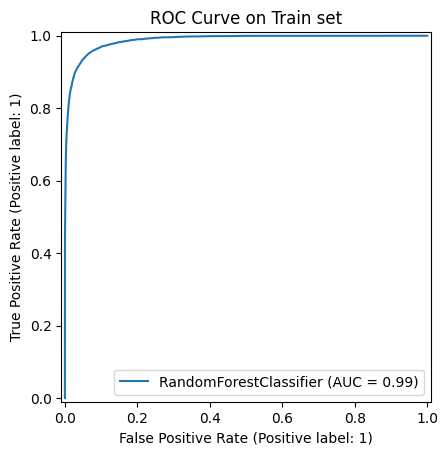

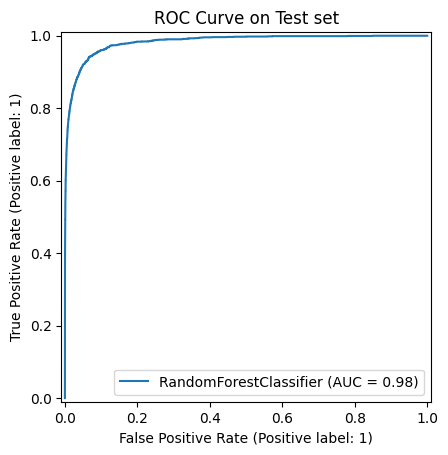

In [15]:
_, ax = plt.subplots()
ax.set(
    title="ROC Curve on Train set"
)  # Set a title that we will add into ConfusionMatrixDisplay
RocCurveDisplay.from_estimator(
    best_rf_model, X_train, Y_train, ax=ax
)  # RocCurveDisplay from sklearn
plt.show()

_, ax = plt.subplots()  # Get subplot from matplotlib
ax.set(
    title="ROC Curve on Test set"
)  # Set a title that we will add into ConfusionMatrixDisplay
RocCurveDisplay.from_estimator(
    best_rf_model, X_test, Y_test, ax=ax
)  # RocCurveDisplay from sklearn
plt.show()

**Our baseline model reaches a f1-score of almost 70%. Now, feel free to refine your model and try to beat this score ! 🚀🚀**

# Train best classifier on all data and use it to make predictions on X_without_labels
**Before making predictions on the file conversion_data_test.csv, let's train our model on ALL the data that was in conversion_data_train.csv. Sometimes, this allows to make tiny improvements in the score because we're using more examples to train the model.**

In [16]:
# Concatenate our train and test set to train your best classifier on all data with labels
X = np.append(X_train,X_test,axis=0)
Y = np.append(Y_train,Y_test)

best_rf_model.fit(X,Y)

RandomForestClassifier(max_depth=10, max_features='log2', min_samples_leaf=4,
                       min_samples_split=3, n_jobs=-1, random_state=42)

In [17]:
# Read data without labels
data_without_labels = pd.read_csv('../data/raw/conversion_data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)

print(data_without_labels.head())

Prediction set (without labels) : (31620, 5)
  country  age  new_user  source  total_pages_visited
0      UK   28         0     Seo                   16
1      UK   22         1  Direct                    5
2   China   32         1     Seo                    1
3      US   32         1     Ads                    6
4   China   25         0     Seo                    3


In [18]:
data_without_labels['total_pages_visited_x2'] = data_without_labels['total_pages_visited'] ** 2
data_without_labels['total_pages_visited_age'] = data_without_labels['total_pages_visited'] * data_without_labels['age']
data_without_labels['total_pages_visited_age_x2'] = (data_without_labels['total_pages_visited'] * data_without_labels['age']) ** 2 

In [19]:
# WARNING : PUT HERE THE SAME PREPROCESSING AS FOR YOUR TEST SET
# CHECK YOU ARE USING X_without_labels
print("Encoding categorical features and standardizing numerical features...")

X_without_labels = preprocessor.transform(data_without_labels)
print("...Done")
print(X_without_labels[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[-0.30941143 -1.47744289  3.32674998  4.1986833   2.78332904  3.09585156
   0.          1.          0.          0.          1.        ]
 [-1.03585553  0.67684511  0.03723927 -0.18903911 -0.34974221 -0.39545186
   0.          1.          0.          1.          0.        ]
 [ 0.17488463  0.67684511 -1.15894645 -0.64490638 -1.07275865 -0.60048291
   0.          0.          0.          0.          1.        ]
 [ 0.17488463  0.67684511  0.3362857   0.01990005  0.410352    0.06296174
   0.          0.          1.          0.          0.        ]
 [-0.67263348 -1.47744289 -0.56085359 -0.49295062 -0.67417266 -0.51531246
   0.          0.          0.          0.          1.        ]]


In [20]:
# Make predictions and dump to file
# WARNING : MAKE SURE THE FILE IS A CSV WITH ONE COLUMN NAMED 'converted' AND NO INDEX !
# WARNING : FILE NAME MUST HAVE FORMAT 'conversion_data_test_predictions_[name].csv'
# where [name] is the name of your team/model separated by a '-'
# For example : [name] = AURELIE-model1
data = {
    'converted': best_rf_model.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'],data=data)
Y_predictions.to_csv('../data/processed/conversion_data_test_predictions_Nicolas-Optuna-Random-Forest-fe.csv', index=False)
